In [1]:
import warnings
warnings.filterwarnings("ignore", message=".*show.*")
%matplotlib inline

# El problema del péndulo inverso

## Sistema de control difuso

In [2]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Se define el universo de discurso para la variable lingüística
angerror = ctrl.Antecedent(np.arange(-np.pi, np.pi, np.pi/60), 'angerror')

# Se definen los conjuntos borrosos
angerror["-2"] = fuzz.trapmf(angerror.universe, [-np.pi, -np.pi, -np.pi/2, -np.pi/4])
angerror["-1"] = fuzz.trimf(angerror.universe, [-np.pi/2, -np.pi/4, 0])
angerror["0"] = fuzz.trimf(angerror.universe, [-np.pi/4, 0, np.pi/4])
angerror["+1"] = fuzz.trimf(angerror.universe, [0, np.pi/4, np.pi/2])
angerror["+2"] = fuzz.trapmf(angerror.universe, [np.pi/4, np.pi/2, np.pi, np.pi])


varerror = ctrl.Antecedent(np.arange(-np.pi/2, np.pi/2, np.pi/48), 'varerror')

# Se definen los conjuntos borrosos
varerror["-2"] = fuzz.trapmf(varerror.universe, [-np.pi/2, -np.pi/2, -np.pi/4, -np.pi/8])
varerror["-1"] = fuzz.trimf(varerror.universe, [-np.pi/4, -np.pi/8, 0])
varerror["0"] = fuzz.trimf(varerror.universe, [-np.pi/8, 0, np.pi/8])
varerror["+1"] = fuzz.trimf(varerror.universe, [0, np.pi/8, np.pi/4])
varerror["+2"] = fuzz.trapmf(varerror.universe, [np.pi/8, np.pi/4, np.pi/2, np.pi/2])


# New Antecedent/Consequent objects hold universe variables and membership
# functions

force = ctrl.Consequent(np.arange(-30, 31, 1), 'force')

force["-2"] = fuzz.trimf(force.universe, [-30, -20, -10])
force["-1"] = fuzz.trimf(force.universe, [-20, -10, 0])
force["0"] = fuzz.trimf(force.universe, [-10, 0, 10])
force["+1"] = fuzz.trimf(force.universe, [0, 10, 20])
force["+2"] = fuzz.trimf(force.universe, [10, 20, 30])


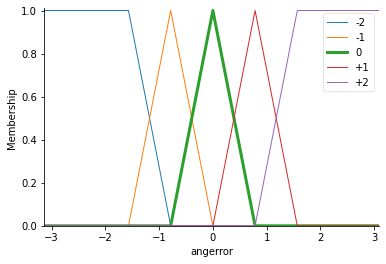

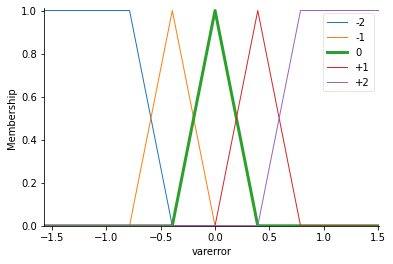

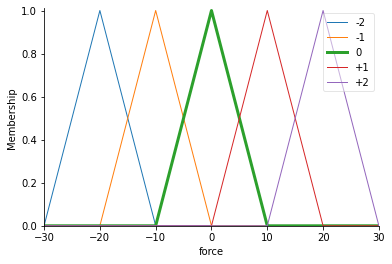

In [3]:
# You can see how these look with .view()
angerror["0"].view()
varerror["0"].view()
force["0"].view()

## Reglas

In [4]:
inv_pend_ctrl = ctrl.ControlSystem([
    # Primera columna de la tabla de reglas
    ctrl.Rule(angerror['-2'] & varerror['-2'], force['+2']),
    ctrl.Rule(angerror['-1'] & varerror['-2'], force['+2']),
    ctrl.Rule(angerror['0'] & varerror['-2'], force['+2']),
    ctrl.Rule(angerror['+1'] & varerror['-2'], force['+1']),
    ctrl.Rule(angerror['+2'] & varerror['-2'], force['0']),
    # Segunda columna de la tabla de reglas
    ctrl.Rule(angerror['-2'] & varerror['-1'], force['+2']),
    ctrl.Rule(angerror['-1'] & varerror['-1'], force['+2']),
    ctrl.Rule(angerror['0'] & varerror['-1'], force['+1']),
    ctrl.Rule(angerror['+1'] & varerror['-1'], force['0']),
    ctrl.Rule(angerror['+2'] & varerror['-1'], force['-1']),
    # Tercera columna de la tabla de reglas
    ctrl.Rule(angerror['-2'] & varerror['0'], force['+2']),
    ctrl.Rule(angerror['-1'] & varerror['0'], force['+1']),
    ctrl.Rule(angerror['0'] & varerror['0'], force['0']),
    ctrl.Rule(angerror['+1'] & varerror['0'], force['-1']),
    ctrl.Rule(angerror['+2'] & varerror['0'], force['-2']),
    # Cuarta columna de la tabla de reglas
    ctrl.Rule(angerror['-2'] & varerror['+1'], force['+1']),
    ctrl.Rule(angerror['-1'] & varerror['+1'], force['0']),
    ctrl.Rule(angerror['0'] & varerror['+1'], force['-1']),
    ctrl.Rule(angerror['+1'] & varerror['+1'], force['-2']),
    ctrl.Rule(angerror['+2'] & varerror['+1'], force['-2']),
    # Quinta columna de la tabla de reglas
    ctrl.Rule(angerror['-2'] & varerror['+2'], force['0']),
    ctrl.Rule(angerror['-1'] & varerror['+2'], force['-1']),
    ctrl.Rule(angerror['0'] & varerror['+2'], force['-2']),
    ctrl.Rule(angerror['+1'] & varerror['+2'], force['-2']),
    ctrl.Rule(angerror['+2'] & varerror['+2'], force['-2']),
])

## Utilizando el control definido

In [5]:
inv_pend = ctrl.ControlSystemSimulation(inv_pend_ctrl)

In [6]:
inv_pend.inputs({
    "angerror": 10 * np.pi / 180,
    "varerror": 0.1
})
inv_pend.compute()

In [7]:
inv_pend.output["force"]

-6.239141435523802

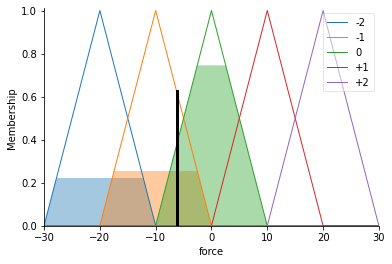

In [8]:
force.view(sim=inv_pend)


# Generamos el escenario con gym

In [16]:
import gym
import time

env = gym.make('CartPole-v1')
env.action_space, env.observation_space

(Discrete(2),
 Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32))

In [17]:
env.env?

Type:        CartPoleEnv
String form: <CartPoleEnv<CartPole-v1>>
File:        ~/.virtualenvs/inteligencia-computacional/lib/python3.7/site-packages/gym/envs/classic_control/cartpole.py
Docstring:  
Description:
    A pole is attached by an un-actuated joint to a cart, which moves along
    a frictionless track. The pendulum starts upright, and the goal is to
    prevent it from falling over by increasing and reducing the cart's
    velocity.

Source:
    This environment corresponds to the version of the cart-pole problem
    described by Barto, Sutton, and Anderson

Observation:
    Type: Box(4)
    Num     Observation               Min                     Max
    0       Cart Position             -4.8                    4.8
    1       Cart Velocity             -Inf                    Inf
    2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
    3       Pole Angular Velocity     -Inf                    Inf

Actions:
    Type: Discrete(2)
    Num   Action
  

In [19]:
max_t = 100  # Máximo tiempo de la simulación
max_episodes = 1  # Máxima cantidad de episodios/repeticiones de la simulación
ang_ref = -10 * (np.pi / 180)

for i_episode in range(max_episodes):
    observation = env.reset()
    
    for t in range(max_t):
        env.render()
        
        # Tomo los datos de los sensores del vehiculo y el problema
        car_pos, car_vel, pole_ang, pole_vel = observation

        angerror_t = ang_ref - pole_ang
        varerror_t = - pole_vel
              
        print(f"En t = {t}: angerror = {angerror_t:.4f} y varerror = {varerror_t:0.4f}")
        
        inv_pend.inputs({
            "angerror": angerror_t,
            "varerror": varerror_t
        })
        inv_pend.compute()
        force_t = inv_pend.output["force"]
        
        print(f"\t  Fuerza = {force_t:0.4f}")
        
        action = env.action_space.sample()
        action = int(force_t > 0)
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
            
        time.sleep(0.1)
    time.sleep(0.1)
            
env.close()

En t = 0: angerror = -0.2156 y varerror = 0.0081
	  Fuerza = 2.8111
En t = 1: angerror = -0.2155 y varerror = 0.2875
	  Fuerza = -3.1292
En t = 2: angerror = -0.2097 y varerror = -0.0178
	  Fuerza = 3.8633
En t = 3: angerror = -0.2101 y varerror = 0.2636
	  Fuerza = -2.7890
En t = 4: angerror = -0.2048 y varerror = -0.0401
	  Fuerza = 4.6929
En t = 5: angerror = -0.2056 y varerror = 0.2429
	  Fuerza = -2.5168
En t = 6: angerror = -0.2008 y varerror = -0.0594
	  Fuerza = 5.3635
En t = 7: angerror = -0.2019 y varerror = 0.2249
	  Fuerza = -2.2729
En t = 8: angerror = -0.1974 y varerror = -0.0763
	  Fuerza = 5.8813
En t = 9: angerror = -0.1990 y varerror = 0.2090
	  Fuerza = -2.0496
En t = 10: angerror = -0.1948 y varerror = -0.0913
	  Fuerza = 6.3128
En t = 11: angerror = -0.1966 y varerror = 0.1950
	  Fuerza = -1.8406
En t = 12: angerror = -0.1927 y varerror = -0.1046
	  Fuerza = 6.5802
En t = 13: angerror = -0.1948 y varerror = 0.1823
	  Fuerza = -1.6470
En t = 14: angerror = -0.1912 y

# Carrito propio

In [12]:
import cartpole_tuar

gym.register(
    id='CartPole-v100',
    entry_point=cartpole_tuar.CartPoleEnv,
    max_episode_steps=500,
    reward_threshold=475.0,
)

In [13]:
envTUAR = gym.make('CartPole-v100')
envTUAR.action_space, envTUAR.observation_space

(Box(-20.0, 20.0, (1,), float32),
 Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32))

In [14]:
envTUAR.env?

Type:        CartPoleEnv
String form: <CartPoleEnv<CartPole-v100>>
File:        ~/projects/inteligencia-computacional/fuzzylogic/cartpole_tuar.py
Docstring:  
Description:
    A pole is attached by an un-actuated joint to a cart, which moves along
    a frictionless track. The pendulum starts upright, and the goal is to
    prevent it from falling over by increasing and reducing the cart's
    velocity.

Source:
    This environment corresponds to the version of the cart-pole problem
    described by Barto, Sutton, and Anderson

Observation:
    Type: Box(4)
    Num     Observation               Min                     Max
    0       Cart Position             -4.8                    4.8
    1       Cart Velocity             -Inf                    Inf
    2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
    3       Pole Angular Velocity     -Inf                    Inf

Actions:
    Type: Box(1)
    Num     Action                    Min                     M

In [21]:
max_t = 100  # Máximo tiempo de la simulación
max_episodes = 1  # Máxima cantidad de episodios/repeticiones de la simulación
ang_ref = 10 * (np.pi / 180)

for i_episode in range(max_episodes):
    observation = envTUAR.reset()
    
    for t in range(max_t):
        envTUAR.render()
        
        # Tomo los datos de los sensores del vehiculo y el problema
        car_pos, car_vel, pole_ang, pole_vel = observation

        angerror_t = ang_ref - pole_ang
        varerror_t = - pole_vel
              
        print(f"En t = {t}: angerror = {angerror_t:.4f} y varerror = {varerror_t:0.4f}")
        
        inv_pend.inputs({
            "angerror": angerror_t,
            "varerror": varerror_t
        })
        inv_pend.compute()
        force_t = inv_pend.output["force"]
        
        print(f"\t  Fuerza = {force_t:0.4f}")
        
        action = [force_t]
        observation, reward, done, info = envTUAR.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
            
        time.sleep(0.1)
    time.sleep(0.1)
            
envTUAR.close()

En t = 0: angerror = 0.2122 y varerror = 0.0497
	  Fuerza = -5.1265
En t = 1: angerror = 0.2132 y varerror = -0.0884
	  Fuerza = -0.4079
En t = 2: angerror = 0.2114 y varerror = -0.0881
	  Fuerza = -0.3951
En t = 3: angerror = 0.2096 y varerror = -0.0880
	  Fuerza = -0.3779
En t = 4: angerror = 0.2079 y varerror = -0.0880
	  Fuerza = -0.3593
En t = 5: angerror = 0.2061 y varerror = -0.0880
	  Fuerza = -0.3404
En t = 6: angerror = 0.2044 y varerror = -0.0880
	  Fuerza = -0.3213
En t = 7: angerror = 0.2026 y varerror = -0.0880
	  Fuerza = -0.3022
En t = 8: angerror = 0.2008 y varerror = -0.0880
	  Fuerza = -0.2831
En t = 9: angerror = 0.1991 y varerror = -0.0880
	  Fuerza = -0.2640
En t = 10: angerror = 0.1973 y varerror = -0.0880
	  Fuerza = -0.2449
En t = 11: angerror = 0.1956 y varerror = -0.0879
	  Fuerza = -0.2258
En t = 12: angerror = 0.1938 y varerror = -0.0879
	  Fuerza = -0.2067
En t = 13: angerror = 0.1920 y varerror = -0.0879
	  Fuerza = -0.1876
En t = 14: angerror = 0.1903 y 